In [5]:
import torch
import torch.nn as nn
import torchvision
import torchsummary
import matplotlib.pyplot as plt
import numpy as np
from torchvision.transforms import ToTensor
from torchsummary import summary
from torch.nn.functional import relu, log_softmax

In [6]:
data_train = torchvision.datasets.MNIST('./data',
        download=True,train=True,transform=ToTensor())
data_test = torchvision.datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())

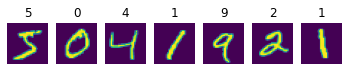

In [7]:
fig,ax = plt.subplots(1,7)
for i in range(7):
    ax[i].imshow(data_train[i][0].view(28,28))
    ax[i].set_title(data_train[i][1])
    ax[i].axis('off')

In [8]:
data_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [9]:
data_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [10]:
print('Training samples:',len(data_train))
print('Test samples:',len(data_test))

print('Tensor size:',data_train[0][0].size())
print('First 10 digits are:', [data_train[i][1] for i in range(10)])

Training samples: 60000
Test samples: 10000
Tensor size: torch.Size([1, 28, 28])
First 10 digits are: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4]


In [11]:
print('Min intensity value: ',data_train[0][0].min().item())
print('Max intensity value: ',data_train[0][0].max().item())

Min intensity value:  0.0
Max intensity value:  1.0


In [12]:
import pytorchcv2

In [13]:
from pytorchcv2 import load_mnist, plot_results

In [14]:
load_mnist()

In [15]:
batch_size = 64
data_train = torchvision.datasets.MNIST('./data',
        download=True,train=True,transform=ToTensor())
data_test = torchvision.datasets.MNIST('./data',
        download=True,train=False,transform=ToTensor())
train_loader = torch.utils.data.DataLoader(data_train,batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(data_test,batch_size=batch_size)

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(28*28,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

net = net.to(device)

In [18]:
print('Digit to be predicted: ',data_train[0][1])
torch.exp(net(data_train[0][0].to(device)))

Digit to be predicted:  5


C:\Users\sroy\Anaconda3\envs\torch\lib\site-packages\torch\nn\modules\container.py:117: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([[0.1273, 0.1511, 0.0993, 0.1030, 0.0810, 0.0792, 0.0743, 0.0928, 0.0912,
         0.1008]], device='cuda:0', grad_fn=<ExpBackward>)

In [19]:
def train_epoch(net,dataloader,lr=0.001,optimizer=None,loss_fn = nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for data in dataloader:
        features, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
    return total_loss.item()/count, acc.item()/count

train_epoch(net,train_loader)    

(0.008617124430338541, 0.8658)

In [20]:
def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for data in dataloader:
            features, labels = data[0].to(device), data[1].to(device)
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

validate(net,test_loader)

(0.0052780986785888676, 0.9087)

In [21]:
def train(net,train_loader,test_loader,optimizer=None,lr=0.001,epochs=10,loss_fn=nn.NLLLoss()):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

In [22]:
# Re-initialize the network to start from scratch
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,10), # 784 inputs, 10 outputs
        nn.LogSoftmax())

net = net.to(device)
hist = train(net,train_loader,test_loader,epochs=10)

Epoch  0, Train acc=0.865, Val acc=0.909, Train loss=0.009, Val loss=0.005
Epoch  1, Train acc=0.909, Val acc=0.918, Train loss=0.005, Val loss=0.005
Epoch  2, Train acc=0.916, Val acc=0.920, Train loss=0.005, Val loss=0.004
Epoch  3, Train acc=0.920, Val acc=0.922, Train loss=0.004, Val loss=0.004
Epoch  4, Train acc=0.923, Val acc=0.924, Train loss=0.004, Val loss=0.004
Epoch  5, Train acc=0.924, Val acc=0.925, Train loss=0.004, Val loss=0.004
Epoch  6, Train acc=0.926, Val acc=0.926, Train loss=0.004, Val loss=0.004
Epoch  7, Train acc=0.926, Val acc=0.926, Train loss=0.004, Val loss=0.004
Epoch  8, Train acc=0.927, Val acc=0.926, Train loss=0.004, Val loss=0.004
Epoch  9, Train acc=0.928, Val acc=0.926, Train loss=0.004, Val loss=0.004


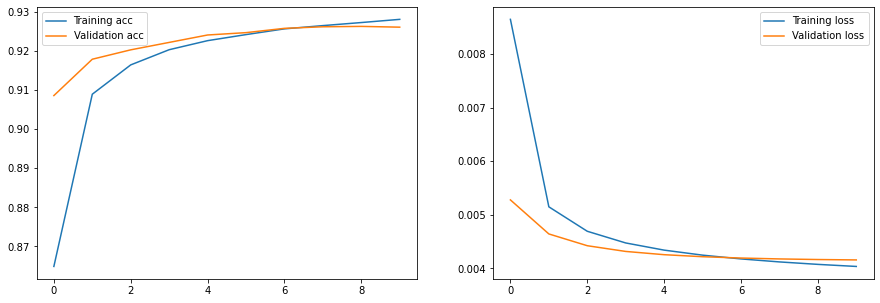

In [23]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist['train_acc'], label='Training acc')
plt.plot(hist['val_acc'], label='Validation acc')
plt.legend()
plt.subplot(122)
plt.plot(hist['train_loss'], label='Training loss')
plt.plot(hist['val_loss'], label='Validation loss')
plt.legend()

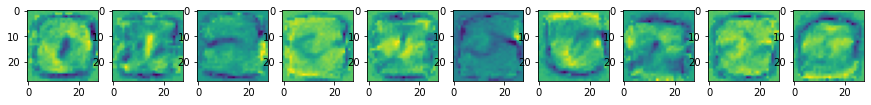

In [24]:
weight_tensor = next(net.parameters())
fig,ax = plt.subplots(1,10,figsize=(15,4))
for i,x in enumerate(weight_tensor):
    ax[i].imshow(x.view(28,28).cpu().detach())

In [25]:
weight_tensor.size()

torch.Size([10, 784])

In [26]:
net = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(784,100),     # 784 inputs, 100 outputs
        nn.ReLU(),              # Activation Function
        nn.Linear(100,10),      # 100 inputs, 10 outputs
        nn.LogSoftmax(dim=0))

net = net.to(device)
summary(net,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
              ReLU-3                  [-1, 100]               0
            Linear-4                   [-1, 10]           1,010
        LogSoftmax-5                   [-1, 10]               0
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [27]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.flatten = nn.Flatten()
        self.hidden = nn.Linear(784,100)
        self.out = nn.Linear(100,10)
        self.log_soft_max = nn.LogSoftmax(dim=0)

    def forward(self, x):
        x = self.flatten(x)
        x = self.hidden(x)
        x = relu(x)
        x = self.out(x)
        x = self.log_soft_max(x)
        return x

net = MyNet()

net = net.to(device)
summary(net,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 100]          78,500
            Linear-3                   [-1, 10]           1,010
        LogSoftmax-4                   [-1, 10]               0
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.30
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


Epoch  0, Train acc=0.909, Val acc=0.946, Train loss=0.037, Val loss=0.034
Epoch  1, Train acc=0.953, Val acc=0.959, Train loss=0.033, Val loss=0.033
Epoch  2, Train acc=0.963, Val acc=0.966, Train loss=0.033, Val loss=0.032
Epoch  3, Train acc=0.969, Val acc=0.968, Train loss=0.032, Val loss=0.032
Epoch  4, Train acc=0.974, Val acc=0.970, Train loss=0.032, Val loss=0.032


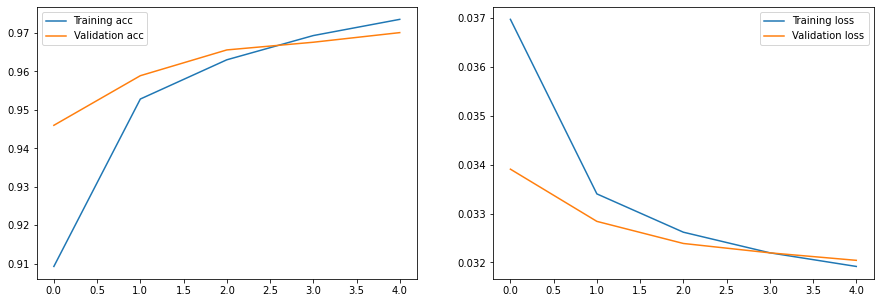

In [28]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)

In [29]:
#Convolutional neural networks

In [60]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np

from pytorchcv2 import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128)

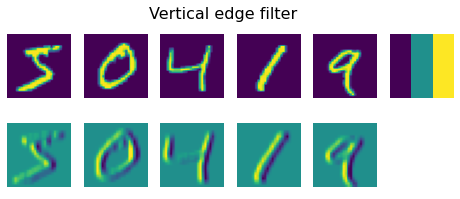

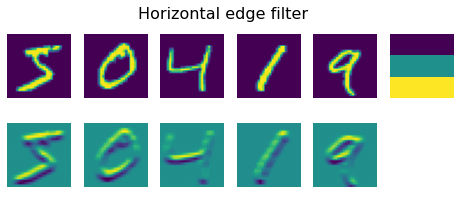

In [35]:
plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')

In [36]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184,10)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = OneConv()

net = net.to(device)
summary(net,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


Epoch  0, Train acc=0.955, Val acc=0.972, Train loss=0.002, Val loss=0.002
Epoch  1, Train acc=0.977, Val acc=0.975, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.983, Val acc=0.980, Train loss=0.001, Val loss=0.001
Epoch  3, Train acc=0.987, Val acc=0.980, Train loss=0.001, Val loss=0.002
Epoch  4, Train acc=0.987, Val acc=0.975, Train loss=0.001, Val loss=0.002


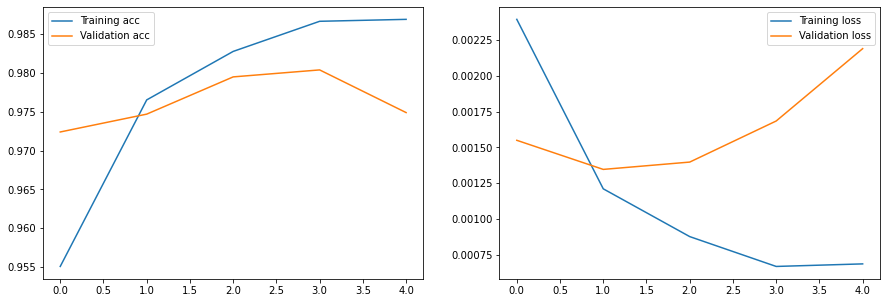

In [37]:
hist = train(net,train_loader,test_loader,epochs=5)
plot_results(hist)

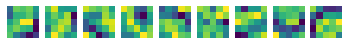

In [38]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

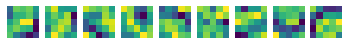

In [39]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

In [40]:
#Multi-Layered CNNs

In [41]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = MultiLayerCNN().to(device)

summary(net,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
         MaxPool2d-2           [-1, 10, 12, 12]               0
            Conv2d-3             [-1, 20, 8, 8]           5,020
         MaxPool2d-4             [-1, 20, 4, 4]               0
            Linear-5                   [-1, 10]           3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.03
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [42]:
hist = train(net,train_loader,test_loader,epochs=5)

Epoch  0, Train acc=0.959, Val acc=0.967, Train loss=0.002, Val loss=0.002
Epoch  1, Train acc=0.979, Val acc=0.975, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.982, Val acc=0.977, Train loss=0.001, Val loss=0.001
Epoch  3, Train acc=0.983, Val acc=0.979, Train loss=0.001, Val loss=0.001
Epoch  4, Train acc=0.985, Val acc=0.981, Train loss=0.001, Val loss=0.001


In [43]:
#CIFAR-10 dataset

In [44]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


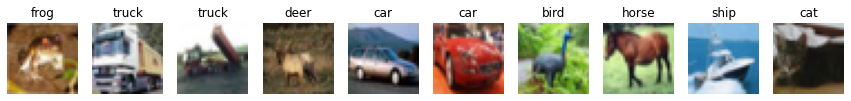

In [45]:
display_dataset(trainset,classes=classes)

In [49]:
#LeNet
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet().to(device)

summary(net,input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 120, 1, 1]          48,120
           Flatten-6                  [-1, 120]               0
            Linear-7                   [-1, 64]           7,744
            Linear-8                   [-1, 10]             650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.23
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


In [58]:
opt = torch.optim.SGD(net.parameters(),lr=0.0001,momentum=0.9)
hist = train(net, trainloader, testloader, epochs=10, optimizer=opt, loss_fn=nn.CrossEntropyLoss())
#hist = train(net, trainloader,testloader,epochs=5,loss_fn=nn.CrossEntropyLoss())

Epoch  0, Train acc=0.121, Val acc=0.122, Train loss=0.161, Val loss=0.161
Epoch  1, Train acc=0.121, Val acc=0.122, Train loss=0.161, Val loss=0.161
Epoch  2, Train acc=0.121, Val acc=0.122, Train loss=0.161, Val loss=0.161
Epoch  3, Train acc=0.121, Val acc=0.122, Train loss=0.161, Val loss=0.161
Epoch  4, Train acc=0.121, Val acc=0.122, Train loss=0.161, Val loss=0.161
Epoch  5, Train acc=0.121, Val acc=0.122, Train loss=0.161, Val loss=0.161
Epoch  6, Train acc=0.121, Val acc=0.122, Train loss=0.161, Val loss=0.161
Epoch  7, Train acc=0.120, Val acc=0.122, Train loss=0.161, Val loss=0.161
Epoch  8, Train acc=0.120, Val acc=0.122, Train loss=0.161, Val loss=0.161
Epoch  9, Train acc=0.119, Val acc=0.122, Train loss=0.161, Val loss=0.161


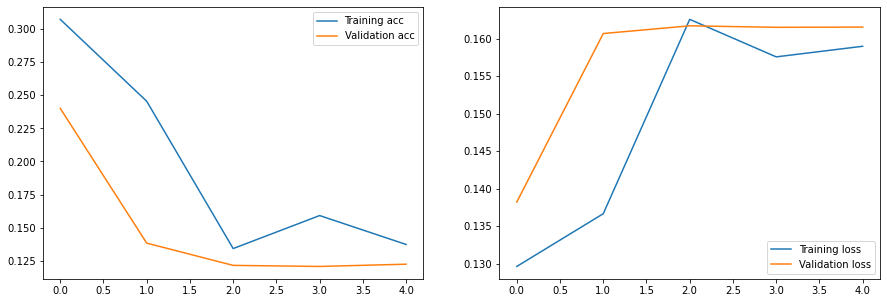

In [57]:
plot_results(hist)

In [65]:
#Use a pre-trained network with transfer learning

In [66]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
import os

from pytorchcv2 import train, plot_results, display_dataset, train_long, check_image_dir

In [67]:
check_image_dir('data/PetImages/Cat/*.jpg')
check_image_dir('data/PetImages/Dog/*.jpg')

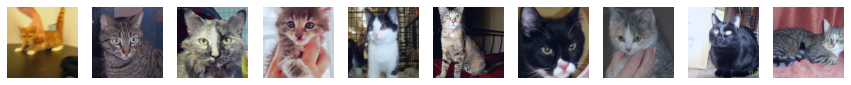

In [68]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(), 
        std_normalize])
dataset = torchvision.datasets.ImageFolder('data/PetImages',transform=trans)
trainset, testset = torch.utils.data.random_split(dataset,[20000,len(dataset)-20000])

display_dataset(dataset)

In [69]:
vgg = torchvision.models.vgg16(pretrained=True)
sample_image = dataset[0][0].unsqueeze(0)
res = vgg(sample_image)
print(res[0].argmax())

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\sroy/.cache\torch\hub\checkpoints\vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

tensor(282)


In [73]:
import json, requests
class_map = json.loads('data/imagenet_class_index.json')
class_map = { int(k) : v for k,v in class_map.items() }

class_map[res[0].argmax().item()]

JSONDecodeError: Expecting value: line 1 column 1 (char 0)